# AXL RNAseq analysis

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from msresist.pre_processing import preprocessing, VarianceFilter
from msresist.plsr import plotR2YQ2Y
from msresist.figures.common import import_phenotype_data, formatPhenotypesForModeling
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from msresist.pca import pca_dfs, plotPCA_scoresORloadings
import pandas as pd
import gseapy as gp

In [25]:
# Set plotting format
matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

## 0. Import and Preprocess RNAseq data

In [3]:
rna = pd.read_feather("msresist/data/RNAseq/AXLmutants_RNAseq_merged.feather").iloc[:, 1:]
idsT = pd.read_csv("msresist/data/RNAseq/transcripts_to_genes.csv")
ids = dict(zip(idsT["ENSEMBL1"], idsT["SYMBOL"]))
rna.insert(0, "Cell Lines", [s[:3] if "M1" in s else s[:2] for s in rna["Cell Line"]])
rna.insert(1, "Treatment", [s[-1] if s[-1] == "E" in s else s[-2:] for s in rna["Cell Line"]])
rna = rna.drop("Cell Line", axis=1)
XIDX = np.any(rna.iloc[:, 2:].values > 10, axis=0)
rna_f = rna.iloc[:, [True, True] + list(XIDX)]
rna_f.iloc[:, 2:] = pd.DataFrame(StandardScaler().fit_transform(rna_f.iloc[:, 2:]))
rna_f.columns = ["Cell Lines", "Treatment"] + [ids[g] if g in ids.keys() else g for g in list(rna_f.columns[2:])]
rna_f = rna_f.set_index("Cell Lines").T
rna_f = rna_f.rename(columns={"KD":"KD", "PC9":"WT", "M4": "Y634F", "M5":"Y643F", "M7":"Y698F", "M10":"Y726F", "M11":"Y750F", "M15":"Y821F"}).T.reset_index()
rna_f = rna_f.set_index(["Cell Lines", "Treatment"]).astype(float).reset_index()

/tmp/ipykernel_829221/3992622802.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rna_f.iloc[:, 2:] = pd.DataFrame(StandardScaler().fit_transform(rna_f.iloc[:, 2:]))


In [4]:
def filter_by_EvEAvar(rna_f, savefig=False, perCut=50):
    rnaE = rna_f[rna_f["Treatment"] == "E"].sort_values(by="Cell Lines")
    rnaEA = rna_f[(rna_f["Treatment"] == "EA") | (rna_f["Cell Lines"] == "KO") & ~(rna_f["Treatment"] == "UT")].sort_values(by="Cell Lines")
    ssd = []
    for ii in range(2, rnaE.shape[1]):
        ssd.append(np.sum(np.square(rnaEA.iloc[:, ii].values - rnaE.iloc[:, ii].values)))
    rna_fEA = rna_f.iloc[:, [True, True] + list(ssd >= np.percentile(ssd, perCut))]
    rna_fEA = rna_fEA[rna_fEA["Treatment"] != "UT"].T
    rna_fEA.columns = [c + "-" + t for c, t in list(zip(rna_fEA.iloc[0, :], rna_fEA.iloc[1, :]))]
    rna_fEA = rna_fEA.iloc[2:, :]
    if savefig:
        rna_fEA.to_csv("msresist/WGCNA/WGCNA_input_Filtered_Abundance_and_EvA.txt", sep="\t")        
    return rna_fEA

rna_fEA = filter_by_EvEAvar(rna_f, savefig=False, perCut=50)


In [5]:
rna_fEA = rna_fEA.T.astype(float).reset_index()
rna_fEA.insert(0, "Cell Lines", [s.split("-")[0] for s in rna_fEA["index"]])
rna_fEA.insert(1, "Treatment", [s.split("-")[1] for s in rna_fEA["index"]])
rna_fEA = rna_fEA.drop("index", axis=1)


## 3. PCA

1. Preprocess raw data based on abundance and variance. Make sure AXL is present
2. Make another file version filtering only extremely low transcripts out for GSEA
3. Run PCA
    - Plot Scores
    - Try to predict using Scores of PCA with EA data only

### PCA Scores

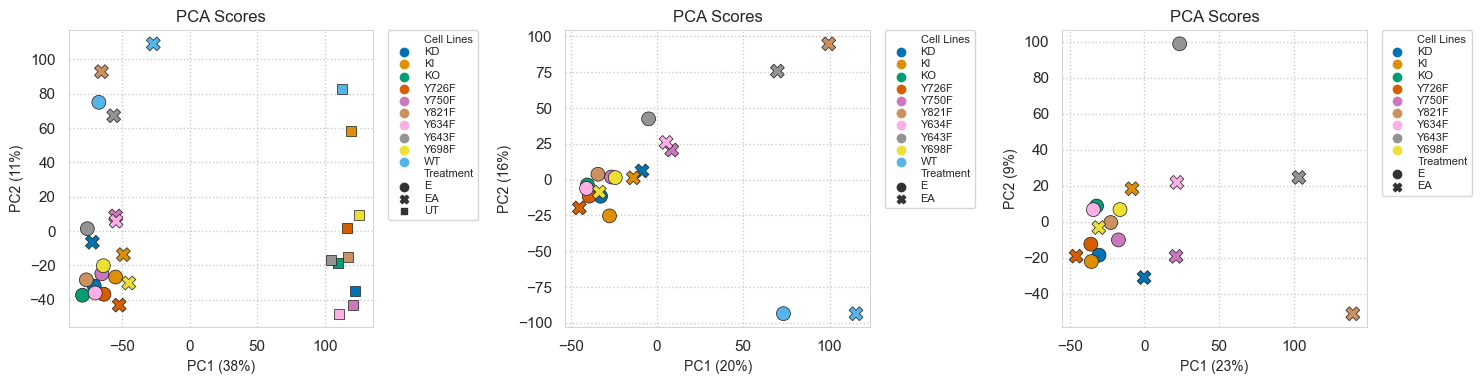

In [6]:
_, ax = plt.subplots(1, 3, figsize=(15, 4))

plotPCA_scoresORloadings(ax[0], rna_f, 2, ["Cell Lines", "Treatment"], hue_scores="Cell Lines", style_scores="Treatment", legendOut=True, plot="scores")
plotPCA_scoresORloadings(ax[1], rna_f[rna_f["Treatment"] != "UT"], 2, ["Cell Lines", "Treatment"], hue_scores="Cell Lines", style_scores="Treatment", legendOut=True, plot="scores")
plotPCA_scoresORloadings(ax[2], rna_f[(rna_f["Cell Lines"] != "WT") & (rna_f["Treatment"] != "UT")], 2, ["Cell Lines", "Treatment"], hue_scores="Cell Lines", style_scores="Treatment", legendOut=True, plot="scores")
plt.tight_layout()

### 4. GSEA
#### 4.1 Standard

In [12]:
st_gsea_d = rna_f[rna_f["Treatment"] != "UT"]
st_gsea_d.insert(0, "Sample", [c + "_" + t for c, t in list(zip(list(st_gsea_d["Cell Lines"]), list(st_gsea_d["Treatment"])))])
st_gsea_d = st_gsea_d.drop(["Cell Lines", "Treatment"], axis=1).set_index("Sample").T
st_gsea_d = st_gsea_d[~st_gsea_d.index.duplicated()]
m = st_gsea_d.columns.str.endswith("_EA")
cols = st_gsea_d.columns[m].tolist() + st_gsea_d.columns[~m].tolist()
st_gsea_d = st_gsea_d[cols]
samples = [s.split("_")[1] for s in cols]

In [13]:
# GO
gsea_rnaf_go = gp.gsea(data=st_gsea_d, 
                 gene_sets='GO_Biological_Process_2021', 
                 cls= samples, 
                 # set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype',
                 permutation_num=100, 
                #  outdir='/home/marcc/AXLomics/msresist/data/RNAseq/GSEA/AXL_RNAseq_gsea/GSEA_rnaF_EvsEA_GO21',
                 outdir=None,
                 method='signal_to_noise',
                 processes=4, seed= 7,
                 format='png')

/tmp/ipykernel_829221/1717402650.py:2: DeprecationWarning: processes is deprecated; use threads
  gsea_rnaf_go = gp.gsea(data=st_gsea_d,
/home/marcc/.local/lib/python3.9/site-packages/gseapy/gsea.py:110: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_std = df.groupby(by=cls_dict, axis=1).std()
/home/marcc/.local/lib/python3.9/site-packages/gseapy/gsea.py:168: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_std = df.groupby(by=classes, axis=1).std()


In [54]:
# WP
gsea_rnaf_wp = gp.gsea(data=st_gsea_d, 
                 gene_sets='WikiPathway_2021_Human',
                 cls= samples, 
                 # set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype',
                 permutation_num=100,
                #  outdir='/home/marcc/AXLomics/msresist/data/RNAseq/GSEA/AXL_RNAseq_gsea/GSEA_rnaF_EvsEA_WP21',
                outdir=None,
                 method='signal_to_noise',
                 processes=4, seed= 7,
                 format='png')

/tmp/ipykernel_829221/26402017.py:2: DeprecationWarning: processes is deprecated; use threads
  gsea_rnaf_wp = gp.gsea(data=st_gsea_d,
/home/marcc/.local/lib/python3.9/site-packages/gseapy/gsea.py:110: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_std = df.groupby(by=cls_dict, axis=1).std()
/home/marcc/.local/lib/python3.9/site-packages/gseapy/gsea.py:168: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_std = df.groupby(by=classes, axis=1).std()


In [165]:
wp[]

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,DNA Repair Pathways Full Network WP4946,0.557853,2.102223,0.0,0.027293,0.02,45/120,20.05%,USP1;PRKDC;FANCI;PCNA;BRCA1;CHEK1;NEIL3;POLE;X...
1,gsea,Regulation of sister chromatid separation at t...,0.792106,2.052781,0.0,0.02047,0.03,12/15,15.26%,BUB1;BUB1B;RAD21;CENPE;SMC1A;PTTG1;STAG1;MAD2L...
2,gsea,DNA IR-damage and cellular response via ATR WP...,0.667786,2.048592,0.0,0.013647,0.03,34/80,15.86%,USP1;CDK2;PLK1;PRKDC;FANCI;PCNA;BRCA1;SMC1A;E2...
3,gsea,Cell cycle WP179,0.571416,2.016963,0.0,0.013647,0.04,58/120,26.21%,BUB1;RAD21;CDK2;ORC1;ANAPC1;PLK1;PRKDC;MCM6;TT...
4,gsea,Retinoblastoma gene in cancer WP2446,0.678975,2.007318,0.0,0.010917,0.04,49/87,20.41%,KIF4A;RRM1;CDK2;ORC1;PRKDC;MCM6;TTK;TOP2A;CDC2...
...,...,...,...,...,...,...,...,...,...,...
316,gsea,Gastrin signaling pathway WP4659,-0.127919,-0.4977,1.0,1.0,1.0,15/114,17.23%,MAPK3;SLC9A3;EGFR;BCAR1;MAP3K11;YES1;CDKN2A;RH...
317,gsea,Renin-angiotensin-aldosterone system (RAAS) WP...,-0.168884,-0.490715,1.0,0.992134,1.0,15/44,83.15%,ATF6B;CALM3;CALML5;ATF4;CREB3L1;ATF2;CREB3;CRE...
318,gsea,IL17 signaling pathway WP2112,0.180037,0.484287,0.976744,1.0,1.0,9/32,39.56%,JAK1;MAPK1;GSK3B;TRAF3IP2;PIK3CA;SP1;MAP3K7;MA...
319,gsea,Physiological and pathological hypertrophy of ...,0.164719,0.484162,1.0,0.997479,1.0,7/25,37.38%,RHOA;MAPK1;MAPK8;IL6ST;CALM1;RAC1;CALM2


/tmp/ipykernel_829221/7262407.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wp_selected["Term"] = [t.split("WP")[0] for t in wp_selected["Term"]]
/tmp/ipykernel_829221/7262407.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wp_selected["-log10(p-value)"] = [-np.log10(p + 0.001) for p in wp_selected["NOM p-val"]]
/tmp/ipykernel_829221/7262407.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

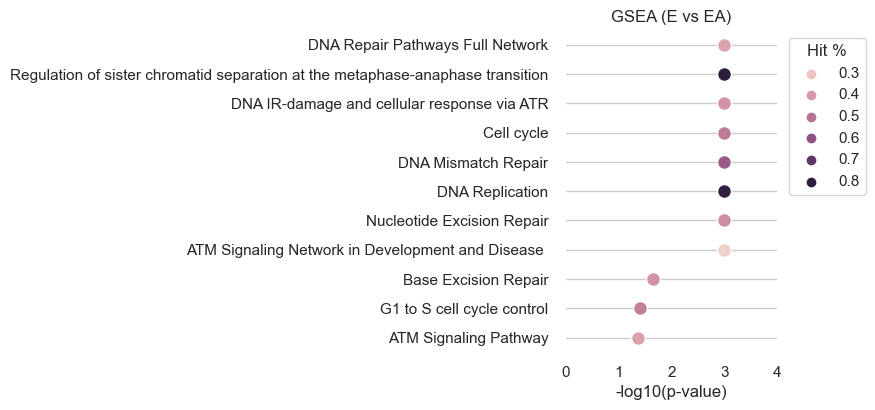

In [158]:
wp_terms = [0, 1, 2, 3, 5, 6, 7, 8, 9, 13, 14]
wp_selected = gsea_rnaf_wp.res2d.iloc[wp_terms, :]
wp_selected["Term"] = [t.split("WP")[0] for t in wp_selected["Term"]]
wp_selected["-log10(p-value)"] = [-np.log10(p + 0.001) for p in wp_selected["NOM p-val"]]
wp_selected["Hit %"] = [np.round(((int(s.split("/")[0]) / int(s.split("/")[1]))), 2) for s in wp_selected["Tag %"]]
g = sns.PairGrid(wp_selected, hue="Hit %",
                 x_vars="-log10(p-value)", y_vars=["Term"],
                 height=4, aspect=.75)
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

g.set(xlim=(0, 4), xlabel="-log10(p-value)", ylabel="")

# Make the grid horizontal instead of vertical
g.axes.flat[0].xaxis.grid(False)
g.axes.flat[0].yaxis.grid(True)
g.axes.flat[0].set_title("GSEA (E vs EA)")
g.axes.flat[0].legend()

sns.despine(left=True, bottom=True)
g.axes.flat[0].legend(title='Hit %', bbox_to_anchor=(1.02, 1))
plt.savefig("GSEA_WP_EvEA.svg")

In [35]:
# OGS
gsea_rnaf_ogs = gp.gsea(data=st_gsea_d, 
                 gene_sets='MSigDB_Oncogenic_Signatures',
                 cls= samples, 
                 # set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype',
                 permutation_num=100,
                #  outdir='/home/marcc/AXLomics/msresist/data/RNAseq/GSEA/AXL_RNAseq_gsea/GSEA_rnaF_EvsEA_OGS21',
                outdir=None,
                 method='signal_to_noise',
                 processes=4, seed= 7,
                 format='png')

/tmp/ipykernel_689653/28857433.py:2: DeprecationWarning: processes is deprecated; use threads
  gsea_rnaf_ogs = gp.gsea(data=st_gsea_d,
/home/marcc/.local/lib/python3.9/site-packages/gseapy/gsea.py:110: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_std = df.groupby(by=cls_dict, axis=1).std()
/home/marcc/.local/lib/python3.9/site-packages/gseapy/gsea.py:168: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_std = df.groupby(by=classes, axis=1).std()


In [36]:
# KEGG
gsea_rnaf_kegg = gp.gsea(data=st_gsea_d, 
                 gene_sets='KEGG_2021_Human',
                 cls= samples, 
                 # set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype',
                 permutation_num=100,
                 outdir='/home/marcc/AXLomics/msresist/data/RNAseq/GSEA/AXL_RNAseq_gsea/GSEA_rnaF_EvsEA_KEGG21',
                 method='signal_to_noise',
                 processes=4, seed= 7,
                 format='png')

/tmp/ipykernel_689653/2378731828.py:2: DeprecationWarning: processes is deprecated; use threads
  gsea_rnaf_kegg = gp.gsea(data=st_gsea_d,
/home/marcc/.local/lib/python3.9/site-packages/gseapy/gsea.py:110: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_std = df.groupby(by=cls_dict, axis=1).std()
/home/marcc/.local/lib/python3.9/site-packages/gseapy/gsea.py:168: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_std = df.groupby(by=classes, axis=1).std()


### PCA EA

In [7]:
n_components = 4
scores_ind = ["Cell Lines"]
loadings_ind = rna_fEA.columns[2:]

ppEA = PCA(n_components=n_components)
dScor_EA = ppEA.fit_transform(rna_fEA.select_dtypes(include=["float64"]))
dLoad_EA = ppEA.components_
dScor_EA, dLoad_EA = pca_dfs(dScor_EA, dLoad_EA, rna_fEA, n_components, scores_ind)
scoresEA = dScor_EA.set_index("Cell Lines")
scoresEA.iloc[:, :] = StandardScaler().fit_transform(dScor_EA.set_index("Cell Lines"))
varExp = np.round(ppEA.explained_variance_ratio_, 2)

dLoad_EA = dLoad_EA.reset_index()
dLoad_EA = dLoad_EA.rename(columns={"index": "Gene"})
rankPCS = dLoad_EA.iloc[:, 1:].abs().sum(axis=1)
dLoad_EA["Sum"] = rankPCS
PCrank = rankPCS.sort_values(ascending=False).index

LoadR_pcs = dLoad_EA.iloc[PCrank, :]
LoadR_pcs = LoadR_pcs[["Gene", "Sum"]].set_index("Gene")
LoadR_pcs = LoadR_pcs[~LoadR_pcs.index.duplicated()]
LoadR_pcs.iloc[:, :] = StandardScaler().fit_transform(LoadR_pcs)

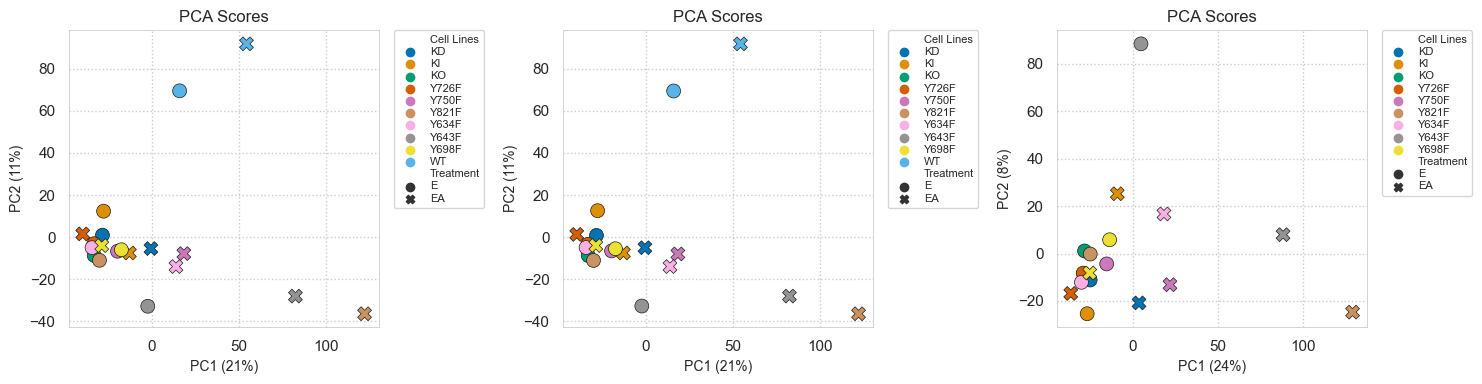

In [8]:
# _, ax = plt.subplots(1, 3, figsize=(15, 4))

# plotPCA_scoresORloadings(ax[0], rna_fEA, 2, ["Cell Lines", "Treatment"], hue_scores="Cell Lines", style_scores="Treatment", legendOut=True, plot="scores")
# plotPCA_scoresORloadings(ax[1], rna_fEA[rna_fEA["Treatment"] != "UT"], 2, ["Cell Lines", "Treatment"], hue_scores="Cell Lines", style_scores="Treatment", legendOut=True, plot="scores")
# plotPCA_scoresORloadings(ax[2], rna_fEA[(rna_fEA["Cell Lines"] != "WT") & (rna_fEA["Treatment"] != "UT")], 2, ["Cell Lines", "Treatment"], hue_scores="Cell Lines", style_scores="Treatment", legendOut=True, plot="scores")
# plt.tight_layout()
# plt.savefig("PCA_EA.svg")

#### 4.1.3 PCA loadings ranked by PC1

In [9]:
dPC1 = dLoad_EA.reset_index().sort_values(by="PC1", ascending=False)[["Gene", "PC1"]]
dPC1 = dPC1[~dPC1.index.duplicated()].set_index("Gene")
dPC1.iloc[:, :] = StandardScaler().fit_transform(dPC1)

In [10]:
# WP
gs_pc1_wp = gp.prerank(rnk=dPC1, gene_sets='WikiPathway_2021_Human',
                     processes=4,
                     permutation_num=100,
                    #  outdir='/home/marcc/AXLomics/msresist/data/RNAseq/GSEA/AXL_RNAseq_gsea/GSEA_PC1_WP21',
                     outdir=None,
                     format='png',
                     seed=6)

SyntaxError: invalid syntax (975162549.py, line 7)

In [10]:
# OGS
gs_pc1_ogs = gp.prerank(rnk=dPC1, gene_sets='MSigDB_Oncogenic_Signatures',
                     processes=4,
                     permutation_num=100,
                    #  outdir='/home/marcc/AXLomics/msresist/data/RNAseq/GSEA/AXL_RNAseq_gsea/GSEA_PC1_OGS',
                     outdir=None,
                     format='png', 
                     seed=6)

/tmp/ipykernel_829221/148203645.py:2: DeprecationWarning: processes is deprecated; use threads
  gs_pc1_ogs = gp.prerank(rnk=dPC1, gene_sets='MSigDB_Oncogenic_Signatures',
2022-09-25 16:23:39,342 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!


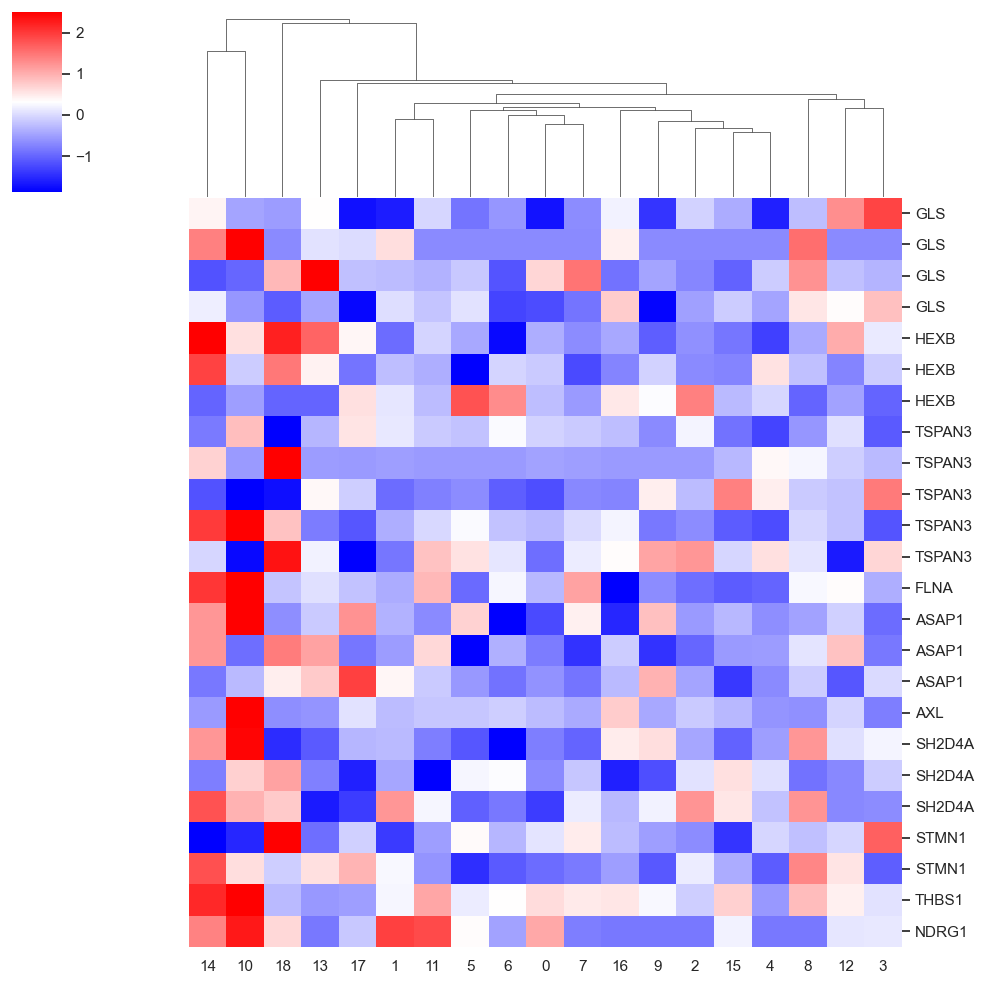

In [11]:
yapIDX = gs_pc1_ogs.res2d[gs_pc1_ogs.res2d["Term"] == "CORDENONSI YAP CONSERVED SIGNATURE"].index[0]
yap_genes = gs_pc1_ogs.res2d.Lead_genes[yapIDX].split(";")
rna_fEA = rna_fEA.sort_values(by="Treatment", ascending=False)
sns.clustermap(rna_fEA.loc[:, yap_genes].T, robust=True, cmap="bwr", col_cluster=True, row_cluster=False)

<AxesSubplot: xlabel='Cell Lines-Treatment'>

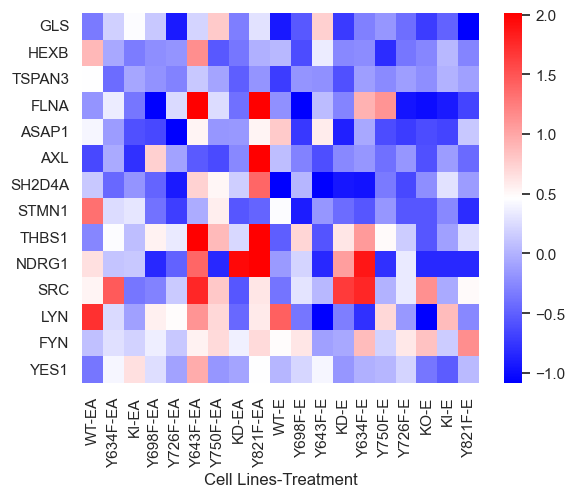

In [30]:
# rna_fEA = rna_fEA.set_index(["Cell Lines", "Treatment"])
rna_fEA = rna_fEA.groupby(by=rna_fEA.columns, axis=1).median()
sns.heatmap(rna_fEA.loc[:, yap_genes + ["SRC", "LYN", "FYN", "YES1"]].T, robust=True, cmap="bwr")

In [54]:
# KEGG
gs_pc1_kegg = gp.prerank(rnk=dPC1, gene_sets='KEGG_2021_Human',
                     processes=4,
                     permutation_num=100,
                     outdir='/home/marcc/AXLomics/msresist/data/RNAseq/GSEA/AXL_RNAseq_gsea/GSEA_PC1_KEGG', format='png', seed=6)

/tmp/ipykernel_689653/3384874123.py:2: DeprecationWarning: processes is deprecated; use threads
  gs_pc1_kegg = gp.prerank(rnk=dPC1, gene_sets='KEGG_2021_Human',
2022-09-24 17:15:11,230 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!


### 4.3 GSEA with Full PCA Loadings 

In [31]:
n_components = 4
ppF = PCA(n_components=n_components)
dd = rna_f[rna_f["Treatment"] != "UT"]
dScor_F = ppF.fit_transform(dd.select_dtypes(include=["float64"]))
dLoad_F = ppF.components_
dScor_F, dLoad_F = pca_dfs(dScor_F, dLoad_F, dd, n_components, scores_ind)
scoresF = dScor_F.set_index("Cell Lines")
scoresF.iloc[:, :] = StandardScaler().fit_transform(dScor_F.set_index("Cell Lines"))
varExp = np.round(ppF.explained_variance_ratio_, 2)

#### 4.3.1 Ranked by all PCs 

In [32]:
dLoad_F = dLoad_F.reset_index()
dLoad_F = dLoad_F.rename(columns={"index": "Gene"})
rankPCS = dLoad_F.iloc[:, 1:].abs().sum(axis=1)
dLoad_F["Sum"] = rankPCS
PCrank = rankPCS.sort_values(ascending=False).index

LoadF_pcs = dLoad_F.iloc[PCrank, :]
LoadF_pcs = LoadF_pcs[["Gene", "Sum"]].set_index("Gene")
LoadF_pcs = LoadF_pcs[~LoadF_pcs.index.duplicated()]
LoadF_pcs.iloc[:, :] = StandardScaler().fit_transform(LoadF_pcs)

In [17]:
# GO
gs_pcs_go = gp.prerank(rnk=LoadF_pcs, gene_sets='GO_Biological_Process_2021',
                     processes=4,
                     permutation_num=100,
                     outdir='/home/marcc/AXLomics/msresist/data/RNAseq/GSEA/AXL_RNAseq_gsea/GSEA_PCS_GO', format='png', seed=6)

/tmp/ipykernel_701979/535991058.py:2: DeprecationWarning: processes is deprecated; use threads
  gs_pcs_go = gp.prerank(rnk=LoadF_pcs, gene_sets='GO_Biological_Process_2021',


In [18]:
# WP
gs_pcs_wp = gp.prerank(rnk=LoadF_pcs, gene_sets='WikiPathway_2021_Human',
                     processes=4,
                     permutation_num=100,
                     outdir='/home/marcc/AXLomics/msresist/data/RNAseq/GSEA/AXL_RNAseq_gsea/GSEA_PCS_WP', format='png', seed=6)

/tmp/ipykernel_701979/3561217357.py:2: DeprecationWarning: processes is deprecated; use threads
  gs_pcs_wp = gp.prerank(rnk=LoadF_pcs, gene_sets='WikiPathway_2021_Human',


In [33]:
# OGS
gs_pcs_ogs = gp.prerank(rnk=LoadF_pcs, gene_sets='MSigDB_Oncogenic_Signatures',
                     processes=4,
                     permutation_num=100,
                    #  outdir='/home/marcc/AXLomics/msresist/data/RNAseq/GSEA/AXL_RNAseq_gsea/GSEA_PCS_OGS2',
                     outdir=None,
                     format='png',
                     seed=6)

/tmp/ipykernel_798441/2190718075.py:2: DeprecationWarning: processes is deprecated; use threads
  gs_pcs_ogs = gp.prerank(rnk=LoadF_pcs, gene_sets='MSigDB_Oncogenic_Signatures',


<AxesSubplot: xlabel='Cell Lines-Treatment'>

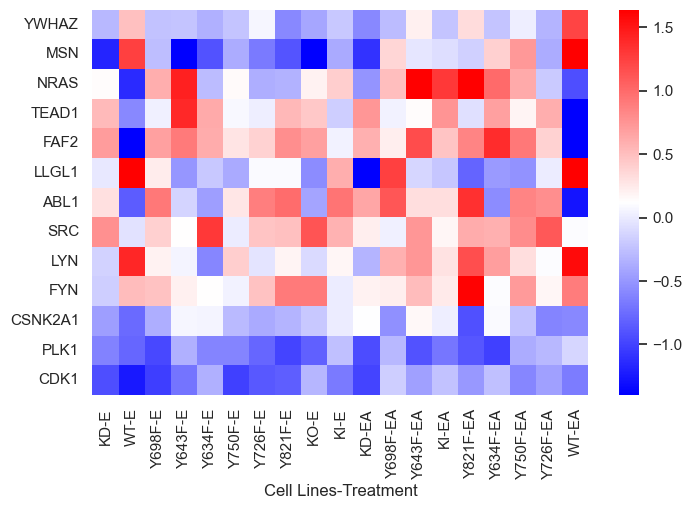

In [55]:
yapIDX = gs_pcs_ogs.res2d[gs_pcs_ogs.res2d["Term"] == "YAP1 UP"].index[0]
yap_genes = gs_pcs_ogs.res2d.Lead_genes[yapIDX].split(";")
rna_f_ = rna_f.sort_values(by="Treatment", ascending=True)
rna_f_ = rna_f_[rna_f_["Treatment"] != "UT"].set_index(["Cell Lines", "Treatment"])
rna_f_ = rna_f_.groupby(by=rna_f_.columns, axis=1).median()
_, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.heatmap(rna_f_.loc[:, yap_genes + ["ABL1", "SRC", "LYN", "FYN", "CSNK2A1", "PLK1", "CDK1"]].T, robust=True, cmap="bwr", ax=ax)

In [20]:
# KEGG
gs_pcs_kegg = gp.prerank(rnk=LoadF_pcs, gene_sets='KEGG_2021_Human',
                     processes=4,
                     permutation_num=100,
                     outdir='/home/marcc/AXLomics/msresist/data/RNAseq/GSEA/AXL_RNAseq_gsea/GSEA_PCS_KEGG', format='png', seed=6)

/tmp/ipykernel_701979/1327854799.py:2: DeprecationWarning: processes is deprecated; use threads
  gs_pcs_kegg = gp.prerank(rnk=LoadF_pcs, gene_sets='KEGG_2021_Human',


### 4.4 Prep input data for ClusterProfiler

In [104]:
# clusPro = pd.melt(rna_f, id_vars=["Cell Lines", "Treatment"], value_vars=rna_f.columns[2:], var_name="Gene", value_name="log(TPM)")
# clusPro = clusPro.rename(columns={"Cell Lines":"Lines"})
# clusPro = clusPro[~clusPro["Gene"].str.startswith("ENST0")].set_index(["Gene", "Treatment", "Lines"])
# clusPro = clusPro[~clusPro.index.duplicated()]

# # Filter based on signal
# XIDX = list((clusPro["log(TPM)"] >= 1) | (clusPro["log(TPM)"] <= -1))
# clusPro_f = clusPro.iloc[XIDX, :]
# clusPro_f.to_csv("RNAseq_CLuPro_Filtered_Input.csv")


In [113]:
# clusPro_f.to_csv("RNAseq_CLuPro_Filtered_Input.csv")

In [47]:
# import mygene

# clusPro_f = clusPro_f.reset_index()
# mg = mygene.MyGeneInfo()
# gg = mg.querymany(list(clusPro_f["Gene"]), scopes="symbol", fields="entrezgene", species="human", returnall=False, as_dataframe=True)
# aa = dict(zip(list(gg.index), list(gg["entrezgene"])))
# for ii in range(clusPro_f.shape[0]):
#     clusPro_f.loc[ii, "Gene"] = aa[clusPro_f.loc[ii, "Gene"]]